# Vision Transformer (ViT) Pytorch MNIST

### Implementasi dan analisis lengkap untuk membangun model ViT dari scratch di PyTorch dan training pada dataset MNIST.

Kode ini adalah bagian dari serial perbandingan antara pembelajaran deep learning Neural Network, CNN-LeNet, dan Vision Transformer (ViT). Semua algoritma menggunakan dataset MNIST dan menggunakan Framework Pytorch.

In [1]:
# Import Package-Package yang diperlukan

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image
import pandas as pd
import torch
from torch import nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.nn.functional import one_hot

%matplotlib inline
np.random.seed(1)

Check CPU/GPU dan Setup Core CPU

In [2]:
print("Cuda Supported : ", torch.cuda.is_available())
print("Cuda Cont :",torch.cuda.device_count())
print("Existing Mode : ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

#torch.set_num_threads(12)  # sesuaikan dengan jumlah core CPU kamu
#torch.set_num_interop_threads(8)

print("Existing CPU Threads  : ",torch.get_num_threads())

Cuda Supported :  False
Cuda Cont : 0
Existing Mode :  cpu
Existing CPU Threads  :  8


# Persiapan dan Analisis Dataset MNIST
## Download Dataset

In [3]:
train_data = MNIST(root="./datasets/", train=True, download=True)
test_data = MNIST(root='./datasets/', train=False, download=True)

## Analisis Dataset MNIST

In [4]:
print("Training set size:", len(train_data))
print("Test set size:", len(test_data))
path = os.path.abspath("./datasets/MNIST/")

print("Dataset MNIST disimpan di:", path)

img, label = train_data[0]
print("Label train_data[0] :", label)
print("Image size (PIL):", img.size)   # Output misalnya: (28, 28)

labels = [label for _, label in train_data]
print("Label unik:", sorted(set(labels)))

print(type(train_data[0][0]), type(train_data[0][1]) )

class_names = train_data.classes
print("Class Name : ", class_names)

Training set size: 60000
Test set size: 10000
Dataset MNIST disimpan di: e:\indobot\vision\comvis\datasets\MNIST
Label train_data[0] : 5
Image size (PIL): (28, 28)
Label unik: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
<class 'PIL.Image.Image'> <class 'int'>
Class Name :  ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [5]:
img, label = train_data[0]
img, label

(<PIL.Image.Image image mode=L size=28x28>, 5)

Tampilkan train_data[0] berupa gambar

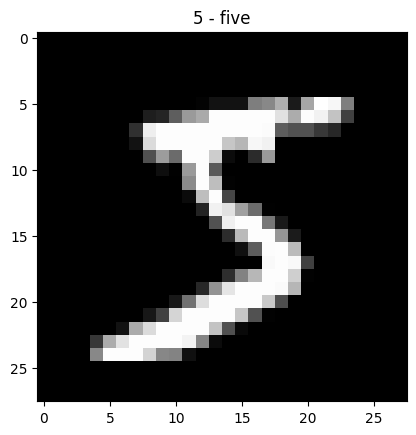

In [6]:
plt.imshow(img, cmap='gray')
plt.title(f"{class_names[label]}");

In [7]:
def img_pixel_superimpose(img, ax):
    w, h = img.shape
    color_map = plt.cm.get_cmap('gray_r')  # gray_reversed
    ax.imshow(img, cmap='gray')
    for x in range(w):
        for y in range(h):
            color = color_map(img[x][y])
            ax.annotate(str(img[x][y]), xy=(y,x), horizontalalignment='center', verticalalignment='center',
                        color=color)
            plt.axis(False)

Tampilkan train_data[0] berupa gambar yang lebih informatif

C:\Users\first\AppData\Local\Temp\ipykernel_18468\951538501.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('gray_r')  # gray_reversed


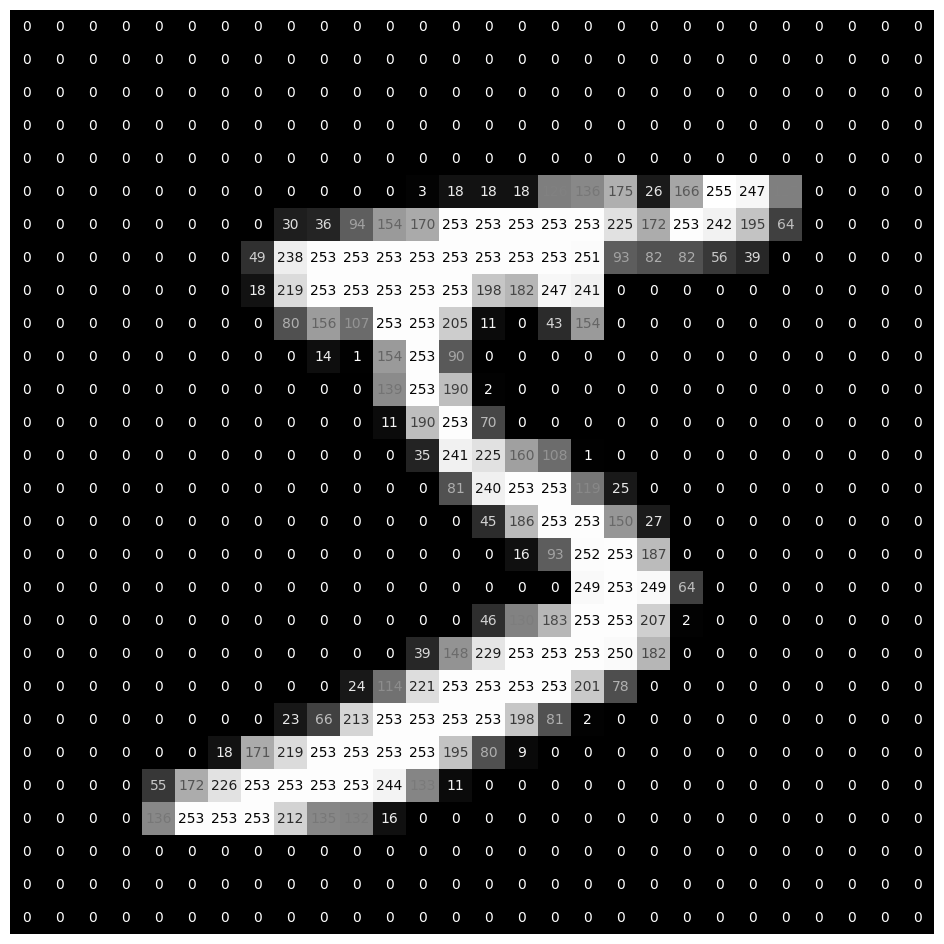

In [8]:
#torch.manual_seed(42)

fig = plt.figure(figsize = (12,12)) 
ax0 = fig.add_subplot(1, 1, 1)

rand_ind = torch.randint(0, len(train_data), size=[1]).item()

img0 = train_data.data[0]
# img0 = train_data.data[rand_ind]
img0 = img0.numpy()
img_pixel_superimpose(img0, ax0)

Tampilkan train_data[] secara random untuk analisis

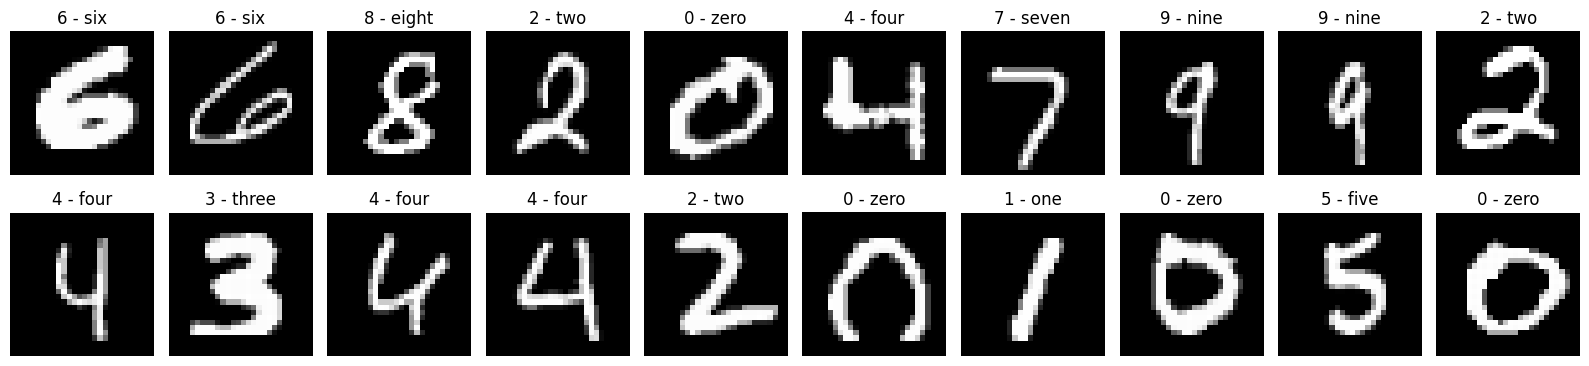

In [9]:
torch.manual_seed(42)     # Search on the internet why '42' is special or
                          # even '42 * 2' = 84

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

## Loading Dataset dari Root tanpa Download Ulang

In [10]:
train_val_dataset = MNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = MNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())

Hitung Mean dan Standar Deviasi (STD) untuk kepentingan Normalisasi Datasets

In [11]:
# Calculate mean and std
imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)

mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
mean, std

(tensor([0.1307]), tensor([0.3081]))

Aplikasikan Mean dan STD untuk Normalisasi dataset dengan fungsi transform

In [12]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

In [13]:
train_val_dataset = MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)
train_val_dataset, test_dataset

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./datasets/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./datasets/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=tensor([0.1307]), std=tensor([0.3081]))
            ))

Bagi Dataset training menjadi dataset untuk Training dan Validasi, dengan komposisi 90% dan 10% dan datanya diacak/random 

In [14]:
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])
len(train_dataset), len(val_dataset)

(54000, 6000)

Pecah data dalam bentuk BATCH

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2,pin_memory=False)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2,pin_memory=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=2,pin_memory=False)

# Let's see no of batches that we have now with the current batch-size
len(train_dataloader), len(val_dataloader), len(test_dataloader) 

(1688, 188, 313)

# Model ViT

## Set Variable Transformer

In [16]:
#variables
batch_size = 64
img_size = 28
patch_size = 7
num_channels = 1
num_patches = (img_size // patch_size) ** 2
num_heads = 1
embed_dim = 16
mlp_dim = 16
transformer_units = 1

Class PatcEmbedding untuk merubah gambar menjadi data embedding

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

Class Trasformer

In [18]:
class TransformerArchitecture(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        residual_1 = x
        attention_output = self.self_attention(self.layer_norm_1(x),self.layer_norm_1(x),self.layer_norm_1(x))[0]
        x = attention_output + residual_1
        residual_2 = x
        mlp_output = self.multi_layer_perceptron(self.layer_norm_2(x))
        x = mlp_output + residual_2
        return x


Class Vision Transformer(ViT)

In [19]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.transformer_layers = nn.Sequential(*[TransformerArchitecture() for _ in range(transformer_units)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )

    def forward(self,x):
        x = self.patch_embedding(x)
        B = x.size(0)

        cls_tokens = self.cls_token.expand(B , -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.transformer_layers(x)
        x = x[:,0]
        x = self.mlp_head(x)
        return x

model_vit = VisionTransformer()

In [20]:
!pip install torchinfo


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Pastikan struktur model sudah sesuai

In [21]:
from torchinfo import summary

summary(model=model_vit, input_size=(1, 1, 28, 28), col_width=20, col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                   [1, 1, 28, 28]       [1, 10]              288                  True
├─PatchEmbedding (patch_embedding)                      [1, 1, 28, 28]       [1, 16, 16]          --                   True
│    └─Conv2d (patch_embed)                             [1, 1, 28, 28]       [1, 16, 4, 4]        800                  True
├─Sequential (transformer_layers)                       [1, 17, 16]          [1, 17, 16]          --                   True
│    └─TransformerArchitecture (0)                      [1, 17, 16]          [1, 17, 16]          --                   True
│    │    └─LayerNorm (layer_norm_1)                    [1, 17, 16]          [1, 17, 16]          32                   True
│    │    └─LayerNorm (layer_norm_1)                    [1, 17, 16]          [1, 17, 16]          (recursive)          True
│  

Definisikan Loss Function, Optimizer yang digunakan

In [22]:
from torchmetrics import Accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_vit.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=10)

In [23]:
!pip install tqdm[notebook]



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Training

In [24]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

from datetime import datetime
import os

# Experiment tracking
timestamp = datetime.now().strftime("%Y-%m-%d")
experiment_name = "MNIST"
model_name = "ViT"
log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
writer = SummaryWriter(log_dir)

# device-agnostic setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
accuracy = accuracy.to(device)
model_vit = model_vit.to(device)

EPOCHS = 12

train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

train_epoch_no.append(0)
train_batch_loss.append(1)
train_batch_accuracy.append(0)

valid_epoch_no.append(0)
valid_batch_loss.append(1)
valid_batch_accuracy.append(0)

for epoch in tqdm(range(EPOCHS)):
    # Training loop
    train_loss, train_acc = 0.0, 0.0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        
        model_vit.train()
        
        y_pred = model_vit(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        acc = accuracy(y_pred, y)
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    train_epoch_no.append(epoch+1)
    train_batch_accuracy.append(train_acc)
    train_batch_loss.append(train_loss)
        
    # Validation loop
    val_loss, val_acc = 0.0, 0.0
    model_vit.eval()
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            
            y_pred = model_vit(X)
            
            loss = loss_fn(y_pred, y)
            val_loss += loss.item()
            
            acc = accuracy(y_pred, y)
            val_acc += acc

            
            
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)

        valid_epoch_no.append(epoch+1)
        valid_batch_accuracy.append(val_acc)
        valid_batch_loss.append(val_loss)
        
    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss, "val/loss": val_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc, "val/acc": val_acc}, global_step=epoch)
    
    print(f"Epoch: {epoch}| Train loss: {train_loss: .5f}| Train acc: {train_acc: .5f}| Val loss: {val_loss: .5f}| Val acc: {val_acc: .5f}")

  8%|▊         | 1/12 [00:25<04:36, 25.16s/it]

Epoch: 0| Train loss:  1.02485| Train acc:  0.66058| Val loss:  0.62401| Val acc:  0.79654


 17%|█▋        | 2/12 [00:50<04:10, 25.04s/it]

Epoch: 1| Train loss:  0.57343| Train acc:  0.81546| Val loss:  0.50510| Val acc:  0.83461


 25%|██▌       | 3/12 [01:15<03:46, 25.20s/it]

Epoch: 2| Train loss:  0.50562| Train acc:  0.83690| Val loss:  0.46661| Val acc:  0.84973


 33%|███▎      | 4/12 [01:40<03:22, 25.30s/it]

Epoch: 3| Train loss:  0.46642| Train acc:  0.84975| Val loss:  0.42704| Val acc:  0.86353


 42%|████▏     | 5/12 [02:06<02:57, 25.37s/it]

Epoch: 4| Train loss:  0.43394| Train acc:  0.86147| Val loss:  0.41037| Val acc:  0.86769


 50%|█████     | 6/12 [02:31<02:32, 25.34s/it]

Epoch: 5| Train loss:  0.40309| Train acc:  0.87154| Val loss:  0.40345| Val acc:  0.86669


 58%|█████▊    | 7/12 [02:56<02:06, 25.27s/it]

Epoch: 6| Train loss:  0.36960| Train acc:  0.88168| Val loss:  0.35932| Val acc:  0.88348


 67%|██████▋   | 8/12 [03:21<01:40, 25.23s/it]

Epoch: 7| Train loss:  0.34502| Train acc:  0.89112| Val loss:  0.35273| Val acc:  0.88331


 75%|███████▌  | 9/12 [03:47<01:15, 25.24s/it]

Epoch: 8| Train loss:  0.32538| Train acc:  0.89714| Val loss:  0.31424| Val acc:  0.89495


 83%|████████▎ | 10/12 [04:14<00:51, 25.72s/it]

Epoch: 9| Train loss:  0.31354| Train acc:  0.90101| Val loss:  0.31372| Val acc:  0.89811


 92%|█████████▏| 11/12 [04:41<00:26, 26.26s/it]

Epoch: 10| Train loss:  0.30381| Train acc:  0.90410| Val loss:  0.28780| Val acc:  0.90775


100%|██████████| 12/12 [05:07<00:00, 25.63s/it]

Epoch: 11| Train loss:  0.29639| Train acc:  0.90568| Val loss:  0.28151| Val acc:  0.90575


## Simpan hasil Training

In [25]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vit_mnist.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Saving the model
print(f"Saving the model: {MODEL_SAVE_PATH}")
torch.save(obj=model_vit.state_dict(), f=MODEL_SAVE_PATH)

# Loading the saved model
model_vit_mnist_loaded = VisionTransformer()
model_vit_mnist_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH))

Saving the model: models\vit_mnist.pth


<All keys matched successfully>

## Infenrence model dengan test_dataloader

In [26]:
test_loss, test_acc = 0, 0

model_vit_mnist_loaded.to(device)

model_vit_mnist_loaded.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model_vit_mnist_loaded(X)
        
        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)
        
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.27567| Test acc:  0.91494


In [27]:

train_epoch_no, train_batch_accuracy,train_batch_loss

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [0,
  tensor(0.6606),
  tensor(0.8155),
  tensor(0.8369),
  tensor(0.8497),
  tensor(0.8615),
  tensor(0.8715),
  tensor(0.8817),
  tensor(0.8911),
  tensor(0.8971),
  tensor(0.9010),
  tensor(0.9041),
  tensor(0.9057)],
 [1,
  1.0248472537068536,
  0.573428961311542,
  0.5056219946072211,
  0.46641836784585816,
  0.43394153571789157,
  0.403093752866143,
  0.36960018167307523,
  0.34501546783531656,
  0.3253830443136394,
  0.3135416145763091,
  0.30380572330965816,
  0.2963923766052624])

# Tampilan Grafik Training

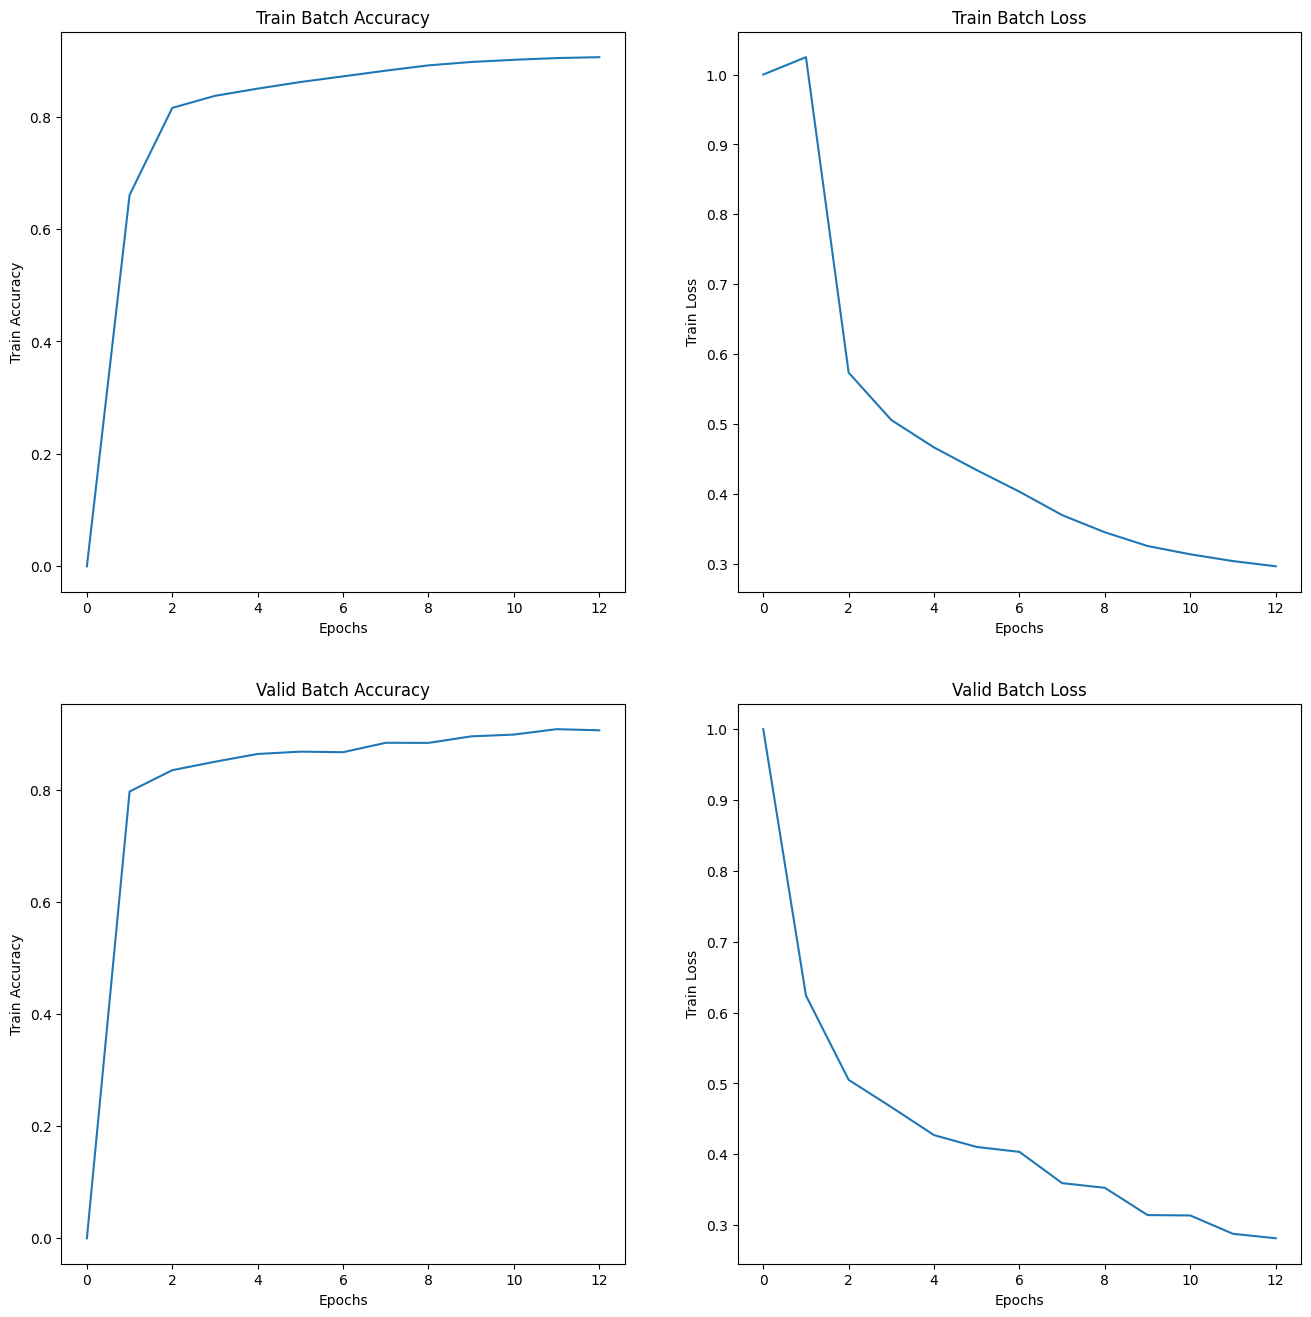

In [28]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 


plt.show()